In [43]:
#!pip install WordCloud
#!pip install pixiedust
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re, string
import collections
import random

from wordcloud   import WordCloud, STOPWORDS

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,auc
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize


In [44]:
def random_colors(number_of_colors):
    '''Input = number of colors you want to generate
       Outpout = list of colors generated'''
    colors=[]
    for i in range(number_of_colors):
        colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)] ))
      
    return colors

In [45]:
data = pd.read_csv('Tweets.csv')
data.shape

(14640, 15)

In [46]:
data[['airline_sentiment','airline_sentiment_confidence']].groupby('airline_sentiment').describe()

airline_sentiment_confidence                              \
                                         count      mean       std     min   
airline_sentiment                                                            
negative                                9178.0  0.933365  0.138109  0.3394   
neutral                                 3099.0  0.823303  0.185594  0.3350   
positive                                2363.0  0.872039  0.179478  0.3356   

                                             
                       25%    50%  75%  max  
airline_sentiment                            
negative           1.00000  1.000  1.0  1.0  
neutral            0.66605  0.916  1.0  1.0  
positive           0.67750  1.000  1.0  1.0

In [47]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [48]:

pd.set_option('max_colwidth',None)
display(data['text'].loc[50:70])

50          @VirginAmerica Is flight 769 on it's way? Was supposed to take off 30 minutes ago. Website still shows "On Time" not "In Flight". Thanks.
51                   @VirginAmerica @ladygaga @carrieunderwood Julie Andrews all the way though @ladygaga was very impressive! NO to @Carrieunderwood
52                                                                                               @VirginAmerica wish you flew out of Atlanta... Soon?
53                                                                               @VirginAmerica @ladygaga @carrieunderwood Julie Andrews. Hands down.
54                                                                             @VirginAmerica Will flights be leaving Dallas for LA on February 24th?
55    @VirginAmerica hi! i'm so excited about your $99 LGA-&gt;DAL deal- but i've been trying 2 book since last week &amp; the page never loads. thx!
56                                                                            @VirginAmerica you kno

In [49]:
data.isna().sum()


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [50]:
plt.rcParams['xtick.labelsize'] = 13 
plt.rcParams['ytick.labelsize'] = 13 
plt.rc('axes', labelsize=13)
plt.rc('axes', titlesize=15)

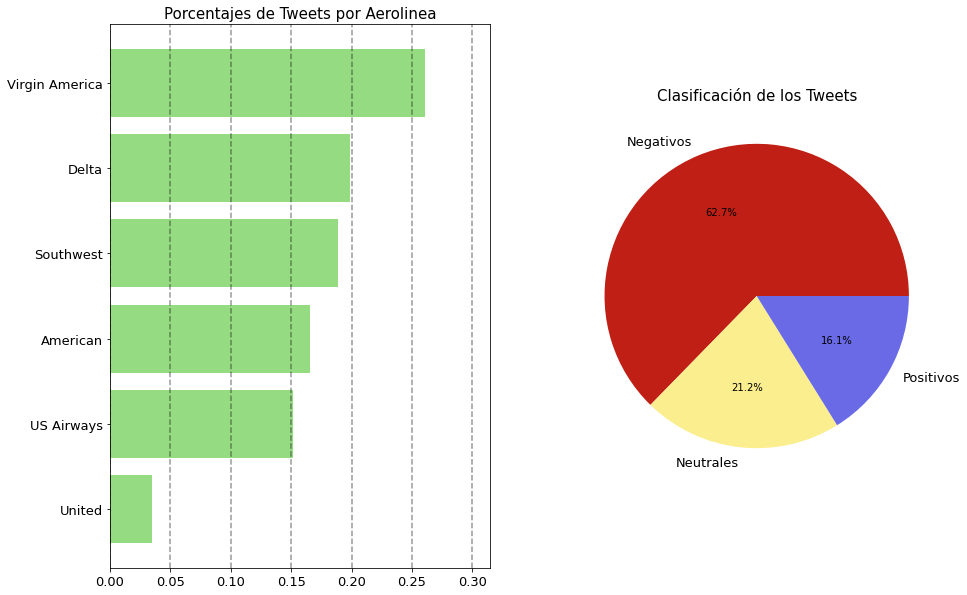

In [51]:
fig,ax = plt.subplots(1,2,figsize=(15,10))
ax = ax.ravel()
ax[0].set_title("Porcentajes de Tweets por Aerolinea", fontsize='15')
ax[1].set_title("Clasificación de los Tweets",fontsize='15')
ax[0].barh(data['airline'].value_counts(normalize = True).index,data['airline'].value_counts(normalize = True,ascending=True).values, color = random_colors(1))
ax[1].pie(data['airline_sentiment'].value_counts(normalize=True),shadow=False,labels=['Negativos','Neutrales','Positivos'],autopct='%1.1f%%',colors = random_colors(3) )
for cord in ax[0].get_xticks():
    ax[0].axvline(x=cord,alpha=0.4,color='k',linestyle='--')

In [52]:
data['tweet_long'] = data['text'].apply(lambda x : len(x))
df =pd.DataFrame( np.round(data['tweet_long'].describe()))
df

,tweet_long
count,14640.0
mean,104.0
std,36.0
min,12.0
25%,77.0
50%,114.0
75%,136.0
max,186.0


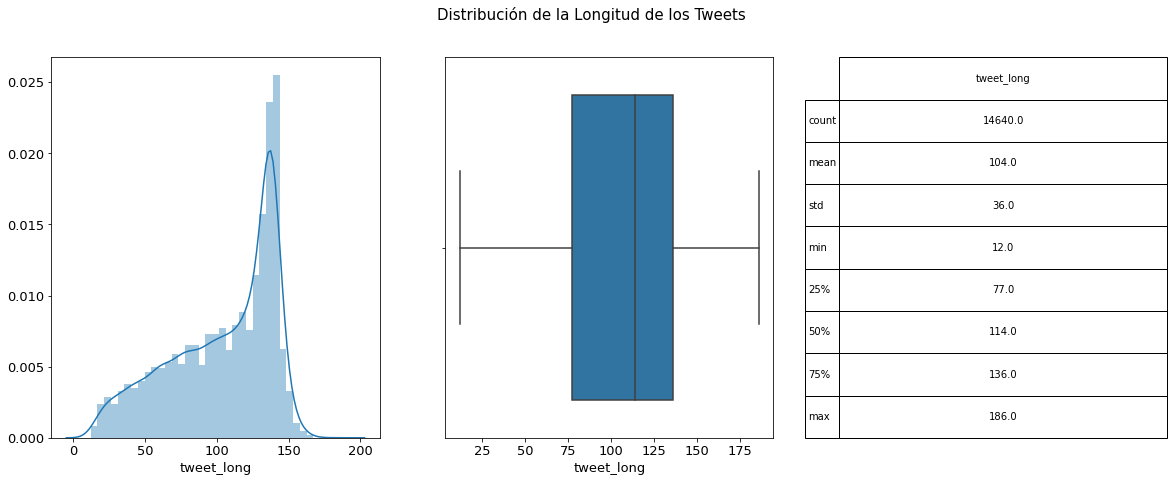

In [53]:
fig, ax = plt.subplots(1,3,figsize=(20,7))
sns.distplot(data['tweet_long'],ax=ax[0])
sns.boxplot(data['tweet_long'],orient='h',ax=ax[1])
fig.suptitle("Distribución de la Longitud de los Tweets", fontsize=15)
ax[2].axis('off')
bbox=[0, 0, 1, 1]
mpl_table = ax[2].table(cellText = df.values, rowLabels = df.index,bbox=[0, 0, 1, 1], colLabels=df.columns,cellLoc ='center')
mpl_table.auto_set_font_size(False)


In [54]:

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~'), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('thanks', 'thank', text)
    text = re.sub('amp', 'it is not my problem', text)
    #text = re.sub('dm', 'direct message', text)
    for i in ['virginamerica','americanair','usairways','southwestair','jetblue','united','flight']: 
        text = text.replace(i,'')
    
    return text

data['text_clean'] = data['text'].apply(lambda x : clean_text(x))


In [55]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['text_clean'] = data['text_clean'].apply(lambda x : remove_emoji(x))


In [56]:
#List of stop words
stop_words=stopwords.words('english')
added_stop_words=["i'm",'u','ve','get']
for word in added_stop_words:
    stop_words.append(word)



In [57]:
#List of most common words with stop words ('lista')
tweet_list = [tweet for tweet in data['text_clean']]
lista=[]
for tweet in tweet_list:
    words = tweet.split()
    for word in words:
        lista.append(word)
#pd.DataFrame(collections.Counter(lista).most_common(10),columns=['Palabra','Frecuencia']).style.background_gradient(cmap='Blues')
df = pd.DataFrame(collections.Counter(lista).most_common(10),columns=['Palabra','Frecuencia'])

In [58]:
plt.rcParams['xtick.labelsize'] = 13 
plt.rcParams['ytick.labelsize'] = 13 

In [59]:
lista_no_stopWords = []
for tweet in tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            lista_no_stopWords.append(word)

df_no_stopWords = pd.DataFrame(collections.Counter(lista_no_stopWords).most_common(10),columns=['Palabra','Frecuencia'])#.style.background_gradient(cmap='Blues')
            

In [60]:
def plot_comon_words(y,width,title, label=False):
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].barh(y=y,width=width,color=random_colors(1))
    ax[0].invert_yaxis()
    ax[0].set_xlabel('Frecuencia')
    if label == False:
        ax[0].set_title('Con stop words')
    ticks = ax[0].get_xticks()
    minimo = min(ticks)
    maximo = max(ticks)
    paso = ticks[1]- ticks[0]
    #maximo += paso
    #ax[0].set_xlim([0,maximo])
    for tick in np.arange(minimo,maximo,paso):
            ax[0].axvline(x=tick,alpha=0.4,color='k',linestyle='--')
    
    
    if label == False:
        ax[1].barh(df_no_stopWords['Palabra'],df_no_stopWords['Frecuencia'],color=random_colors(1))
        ax[1].invert_yaxis()
        ax[1].set_xlabel('Frecuencia')
        ticks = ax[1].get_xticks()
        minimo = min(ticks)
        maximo = max(ticks)
        paso = ticks[1]- ticks[0]
        for tick in np.arange(minimo,maximo,paso):
            ax[1].axvline(x=tick,alpha=0.4,color='k',linestyle='--')
        plt.suptitle(title,fontsize=17)
        ax[1].set_title('Sin stop words',fontsize=15)
    else:

        if label == 'negative':
            text = ",".join(word for word in list_negative)
            wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
        elif label == 'neutral':
            text = ",".join(word for word in list_neutral if word!='problem')
            wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
        else:
            text = ",".join(word for word in list_positive if word!='problem')
            wordcloud = WordCloud(max_words=30, colormap='Set1',background_color="black").generate(text)
    
        ax[1].imshow(wordcloud, interpolation='bilinear')
        ax[1].axis("off")
        plt.suptitle(title,fontsize=17)
        #plt.figure(1,figsize=(12, 12))
        #plt.title('Palabras más comunes en los tweets',fontsize=19)
        #plt.show()
    
    return

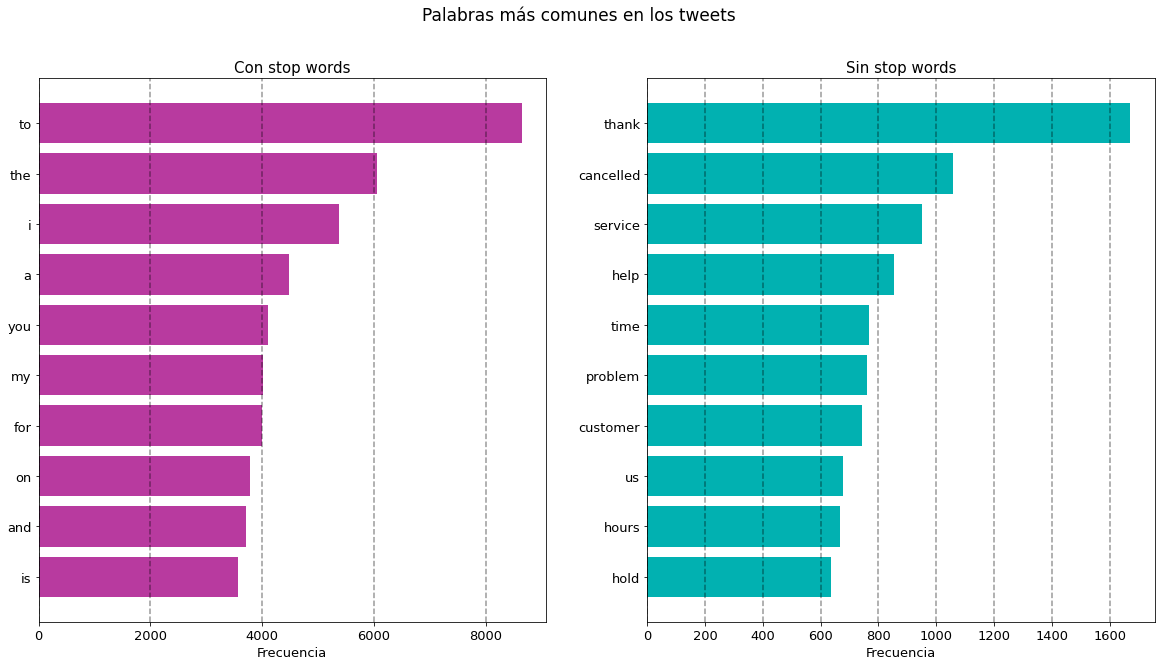

In [61]:
plot_comon_words(df['Palabra'],df['Frecuencia'],title='Palabras más comunes en los tweets',label=False)

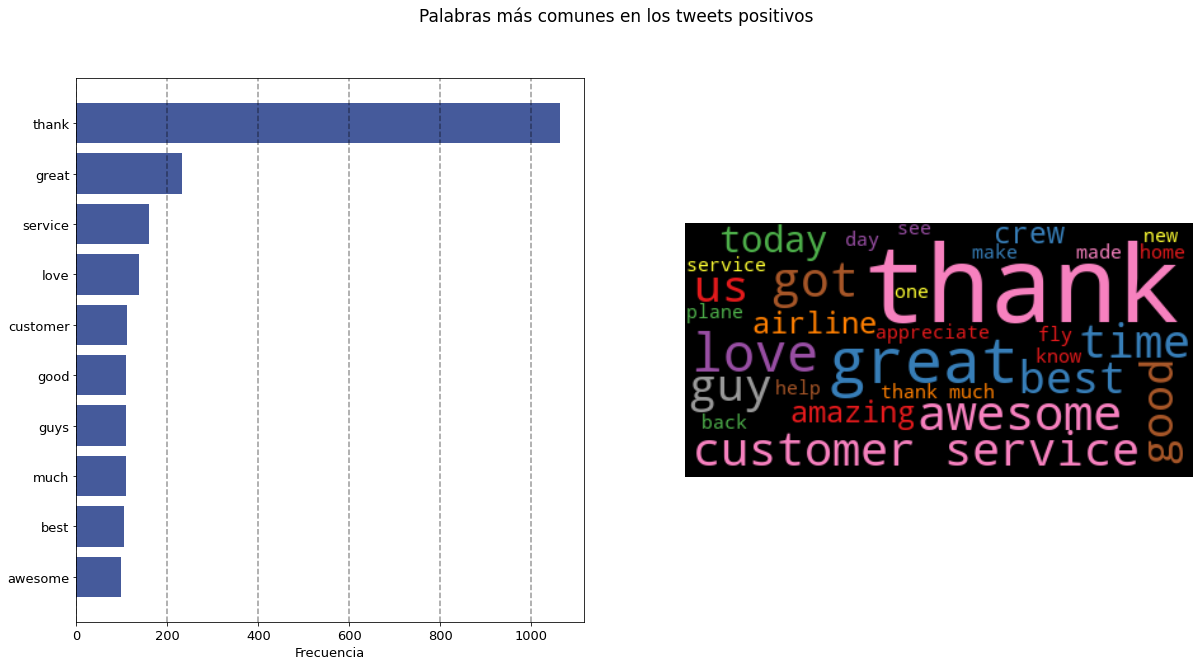

In [62]:
#Visualización de las palabras más comunes según clasificación de Tweet en positivo
mask_positive = data['airline_sentiment'] == 'positive'
data['text_clean'].loc[mask_positive]
positive_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_positive]]
list_positive=[]
for tweet in positive_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_positive.append(word)
            
df_no_stopWords_positive = pd.DataFrame(collections.Counter(list_positive).most_common(10),columns=['Palabra','Frecuencia'])#.style.background_gradient(cmap='Blues')
plot_comon_words(df_no_stopWords_positive['Palabra'],df_no_stopWords_positive['Frecuencia'],'Palabras más comunes en los tweets positivos','positive')

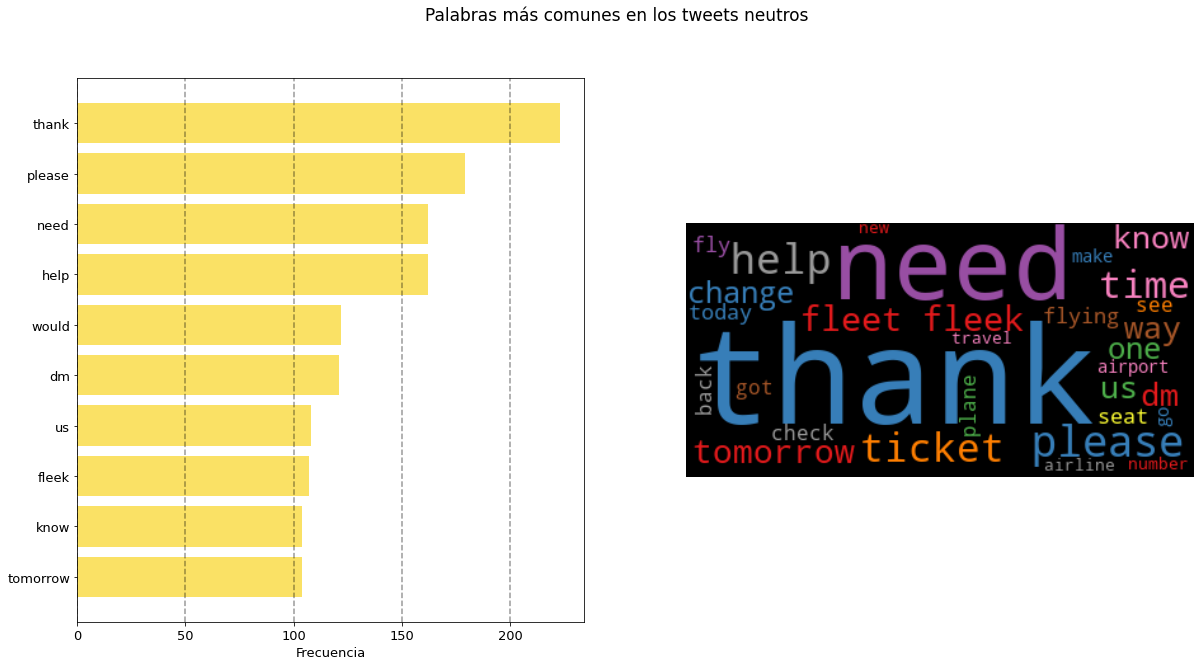

In [63]:
#Visualización de las palabras más comunes según clasificación de Tweet en neutro
mask_neutral = data['airline_sentiment'] == 'neutral'
data['text_clean'].loc[mask_neutral]
neutral_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_neutral]]
list_neutral=[]
for tweet in neutral_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_neutral.append(word)
            
df_no_stopWords_neutral = pd.DataFrame(collections.Counter(list_neutral).most_common(10),columns=['Palabra','Frecuencia'])#.style.background_gradient(cmap='Blues')
plot_comon_words(df_no_stopWords_neutral['Palabra'],df_no_stopWords_neutral['Frecuencia'],'Palabras más comunes en los tweets neutros','neutral')

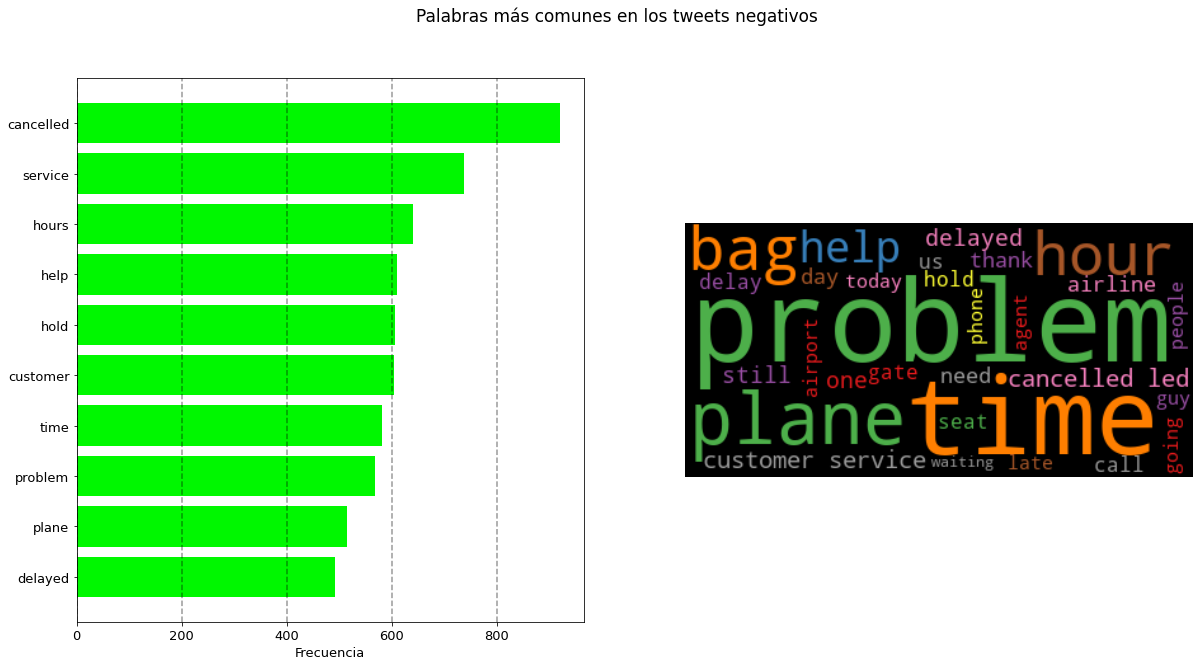

In [64]:
#Visualización de las palabras más comunes según clasificación de Tweet negativo
mask_negative = data['airline_sentiment'] == 'negative'
data['text_clean'].loc[mask_negative]
negative_tweet_list = [tweet for tweet in data['text_clean'].loc[mask_negative]]
list_negative=[]
for tweet in negative_tweet_list:
    words = tweet.split()
    for word in words:
        if word not in stop_words:
            list_negative.append(word)
            
df_no_stopWords_negative = pd.DataFrame(collections.Counter(list_negative).most_common(10),columns=['Palabra','Frecuencia'])#.style.background_gradient(cmap='Blues')
plot_comon_words(df_no_stopWords_negative['Palabra'],df_no_stopWords_negative['Frecuencia'],'Palabras más comunes en los tweets negativos','negative')

In [65]:
def train_test_splits():
    x = data['text_clean']
    y = data['airline_sentiment']
    global train,test,y_train,y_test
    train,test,y_train,y_test = train_test_split( x, y, stratify = y, random_state=49)
    return


In [66]:
def set_vectorizer(kind):
    vectorizer=kind
    global x_train
    global x_test
    x_train = vectorizer.fit_transform(train)
    x_test = vectorizer.transform(test)
    return 
    
#set_vectorizer(TfidfVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1, 1)));

In [67]:
def set_splits(splits):
    global n_splits
    n_splits=splits
    skf = StratifiedKFold(n_splits,random_state=49,shuffle=True) 
    global kfolds
    kfolds = dict.fromkeys(range(n_splits))
    for fold ,(train_index,test_index) in enumerate(skf.split(x_train,y_train)):
        kfolds[fold]=(train_index,test_index)
    return n_splits
    


    
#set_splits(4)

In [68]:
def create_dict():
    '''Creates a dictionary of dictonaries of DataFrames'''
    global labels, results, results_roc
    labels = ['negative','neutral','positive']
    dictionary = dict.fromkeys(labels)
    for i in dictionary.keys():
        dictionary[i] = dict.fromkeys(range(n_splits))
    return dictionary

#results  = create_dict()
#results_roc  = create_dict()

In [69]:
def modelado(estimador):
    
    labels = ['negative','neutral','positive']
   
    for col, label in enumerate(labels):
        for fold in kfolds.keys():
            estimador.fit(x_train[kfolds[fold][0]],y_train.iloc[kfolds[fold][0]])

            #y_test_probs son las probabilidades de pertenecer a la primer etiqueta que es negativa
            y_test_probs = estimador.predict_proba(x_train[kfolds[fold][1]])[:,col]
            y_test = y_train.iloc[kfolds[fold][1]]

            #Cálculo de precision y recall para el label 'negative'


            p_threshold = np.arange(0,1,0.001)
            precision_list=[]
            recall_list=[]
            fpr_list = []

            for p in p_threshold:
                tp=0
                fp=0
                fn=0
                tn=0
                y_pred = []

                for prob in y_test_probs:
                    if prob > p:
                        y_pred.append(label)
                    else:
                        y_pred.append('else')


                for predicted,actual in zip(y_pred,y_test):
                    if actual == label == predicted:
                        tp+=1
                    elif actual!= label and predicted== label:
                        fp+=1
                    elif actual== label and predicted!= label: 
                        fn+=1
                    else:
                        tn+=1


                try:
                    precision_list.append(tp/(tp+fp))
                except:
                    precision_list.append(1)
                try:
                    recall_list.append(tp/(tp+fn))
                except:
                    recall_list.append(1)
                try:
                    fpr_list.append(fp/(fp+tn))
                except:
                    fpr_list.append(1)

            results[label][fold] = pd.DataFrame({'recall':recall_list,'precision':precision_list})
            results_roc[label][fold] = pd.DataFrame({'recall':recall_list,'fpr':fpr_list})
        
    return results,results_roc
            


In [70]:
#Creo un diccionario con las llaves 
def create_means_pr(): 
    '''Crea un data frame del promedio de todos los folds de las curvas recall y precision '''    
    
    labels = ['negative','neutral','positive']
    global means
    means = dict.fromkeys(labels)
    for label in results.keys():
        df=pd.DataFrame()
        for fold in results[label]:
            df = pd.concat([df,results[label][fold]],axis=1)
        df['mean_recall'] = df['recall'].mean(axis=1)
        df['mean_precision'] =df['precision'].mean(axis=1)
        df.drop(columns=['recall','precision'], inplace= True)
        means[label] = df  
    return

def mean_auc(label):
    auc_mean = round(auc(means[label]['mean_recall'],means[label]['mean_precision']),2)
    return auc_mean

#create_means_pr();

In [71]:
def create_means_roc():
    global means_roc
    means_roc = dict.fromkeys(labels)
    for label in results_roc.keys():
        df=pd.DataFrame()
        for fold in results_roc[label]:
            df = pd.concat([df,results_roc[label][fold]],axis=1)
        df['mean_recall'] = df['recall'].mean(axis=1)
        df['mean_fpr'] =df['fpr'].mean(axis=1)
        df.drop(columns=['recall','fpr'], inplace= True)
        means_roc[label] = df  
    return

def mean_roc(label):
    mean_auc_roc = round(-1 * np.trapz(means_roc[label]['mean_recall'],means_roc[label]['mean_fpr']),2)
    return mean_auc_roc

#create_means_roc();

In [97]:
def plot_roc_auc(roc_title):    
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax=ax.ravel()
    

    for i , label in enumerate(results_roc.keys()):
        for fold in results_roc[label]:
            ax[i].plot(results_roc[label][fold]['fpr'],results_roc[label][fold]['recall'],linestyle='--',label = 'fold '+str(fold))
            ax[i].legend()
            ax[i].set_title('Class: ' + str(label))
            ax[i].set_xlabel('False Positive Rate')
            ax[i].set_ylabel('True Positive Rate (Recall)')

    for i,label in enumerate(means_roc.keys()):
        ax[i].plot(means_roc[label]['mean_fpr'],means_roc[label]['mean_recall'],color='k',linewidth=2, label = 'mean')
        ax[i].plot([0,1],[0,1],c='k',linestyle='--',alpha=0.3)
        ax[i].legend(loc=2)
        ax[i].text(ax[i].get_xlim()[0]+0.6,ax[i].get_ylim()[0]+0.1,f'Mean ROC AUC = {mean_roc(label)}',fontsize=12)   

    plt.suptitle(roc_title,fontsize=17)
    return
#plot_roc_auc('ROC Curves (LogisticRegression - CountVectorizer)')

In [73]:
def plot_pr_auc(pr_title):    
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax=ax.ravel()


    for i , label in enumerate(results.keys()):
        for fold in results[label]:
            ax[i].plot(results[label][fold]['recall'],results[label][fold]['precision'],linestyle='--',label = 'fold '+str(fold))
            ax[i].legend()
            ax[i].set_title('Class: ' + str(label))
            ax[i].set_xlabel('Recall')
            ax[i].set_ylabel('Precision')

    for i,label in enumerate(means.keys()):
        ax[i].plot(means[label]['mean_recall'],means[label]['mean_precision'],color='k',linewidth=2, label = 'mean')
        ax[i].legend()

        ax[i].get_xlim()

        if i == 0:
            ax[i].text(ax[i].get_xlim()[0]+0.05,ax[i].get_ylim()[0]+0.025,f'Mean AUC = {mean_auc(label)}',fontsize=12)   
        else:
            ax[i].text(ax[i].get_xlim()[0]+0.05,ax[i].get_ylim()[0]+0.05,f'Mean AUC = {mean_auc(label)}',fontsize=12) 
    plt.suptitle(pr_title,fontsize=17)
    return
#plot_pr_auc('Precision-Recall Curves (LogisticRegression - CountVectorizer)') 

In [74]:
def run_model(kind,splits,estimador,pr_title,roc_title):
    global results,results_roc
    train_test_splits()
    set_vectorizer(kind=kind)
    set_splits(splits=splits)
    results  = create_dict()
    results_roc  = create_dict()
    modelado(estimador=estimador)
    #if str(kind).split('(')[0] == 'TfidfVectorizer' and str(estimador).split('(')[0] == 'MultinomialNB':
        #mask_recall = results['neutral'][1]['recall']== 0
        #mask_precision = results['neutral'][1]['precision']== 0
        #index_recall_0=results['neutral'][1]['recall'].loc[mask_recall].index

        #mask_both = results['neutral'][1].iloc[index_recall_0]['precision'] == 0
        #mask_both[mask_both].index

        #results['neutral'][1].loc[mask_both[mask_both].index,'precision'] = 1

    
    create_means_pr()
    create_means_roc()
    plot_pr_auc(pr_title)
    plot_roc_auc(roc_title)
    return

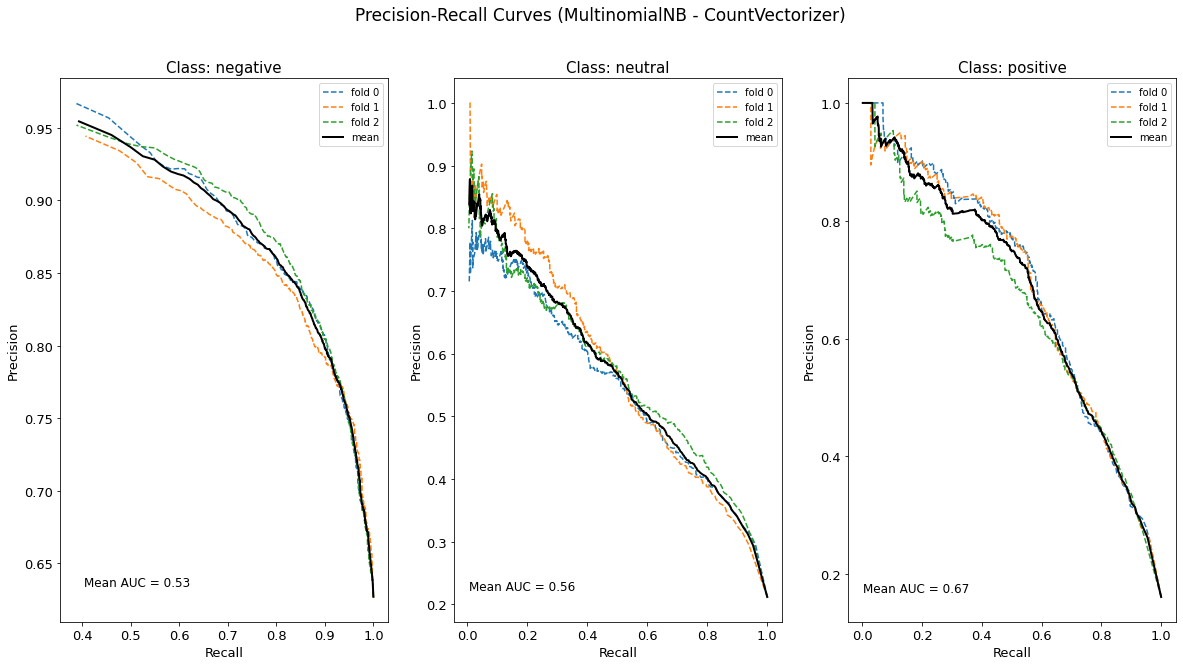

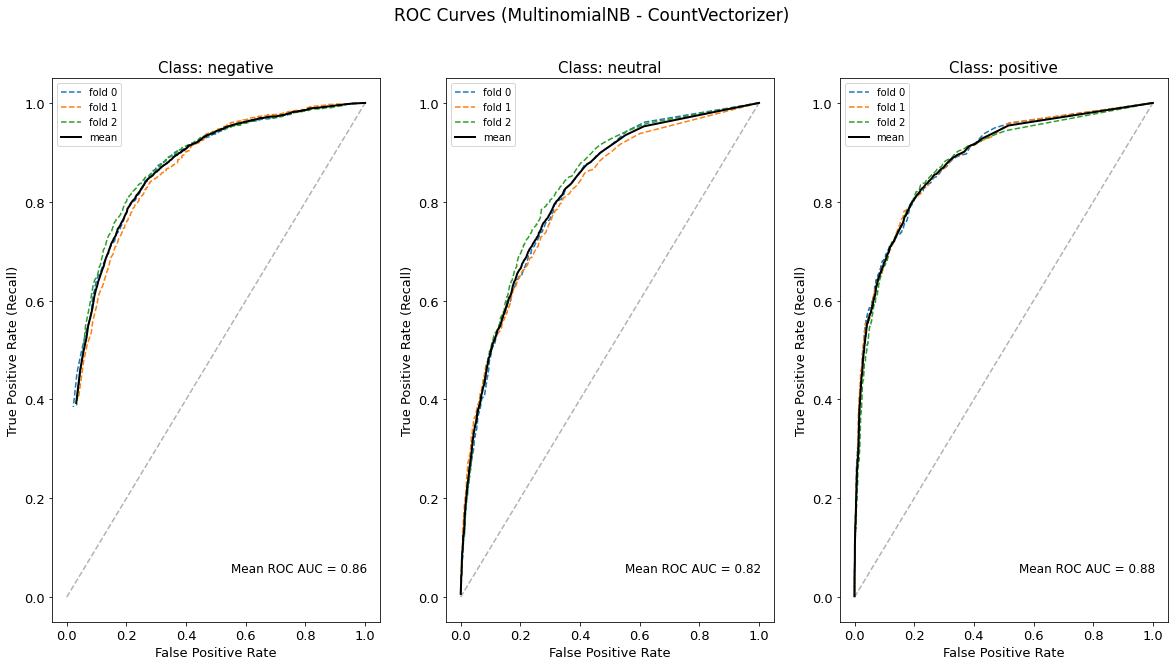

In [98]:
#Tipo de vectorizador
kind = CountVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1, 1))
#Cantidad de kfolds a dividir el dataset
splits = 3
#Seleccion de estimador
estimador = MultinomialNB(alpha=1.8)
#Contiene los nombres del vectorizador y estimador respectivamente
vector_strip = str(kind).split('(')[0]
model_strip = str(estimador).split('(')[0]
#Ploteo de resulados
pr_title = f'Precision-Recall Curves ({model_strip} - {vector_strip})'
roc_title = f'ROC Curves ({model_strip} - {vector_strip})'


run_model(kind,splits,estimador,pr_title,roc_title)


In [76]:

mask_recall = results['neutral'][1]['recall']== 0
mask_precision = results['neutral'][1]['precision']== 0
index_recall_0=results['neutral'][1]['recall'].loc[mask_recall].index

mask_both = results['neutral'][1].iloc[index_recall_0]['precision'] == 0
mask_both[mask_both].index

#results['neutral'][1].loc[mask_both[mask_both].index,'precision'] = 1


Int64Index([], dtype='int64')

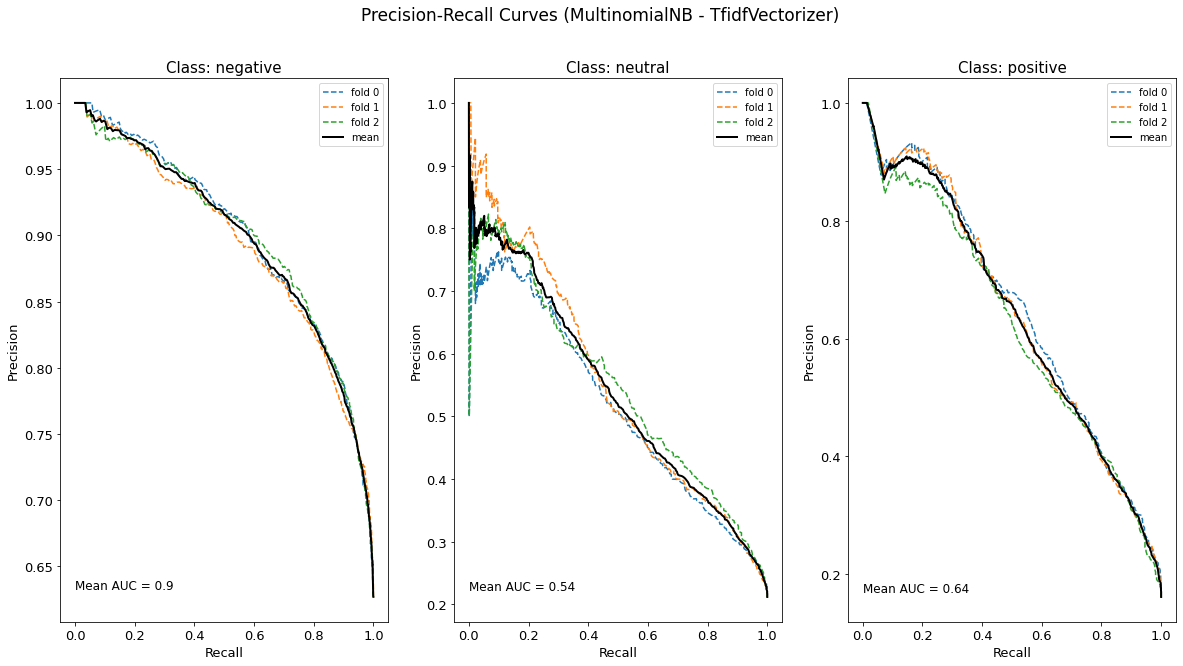

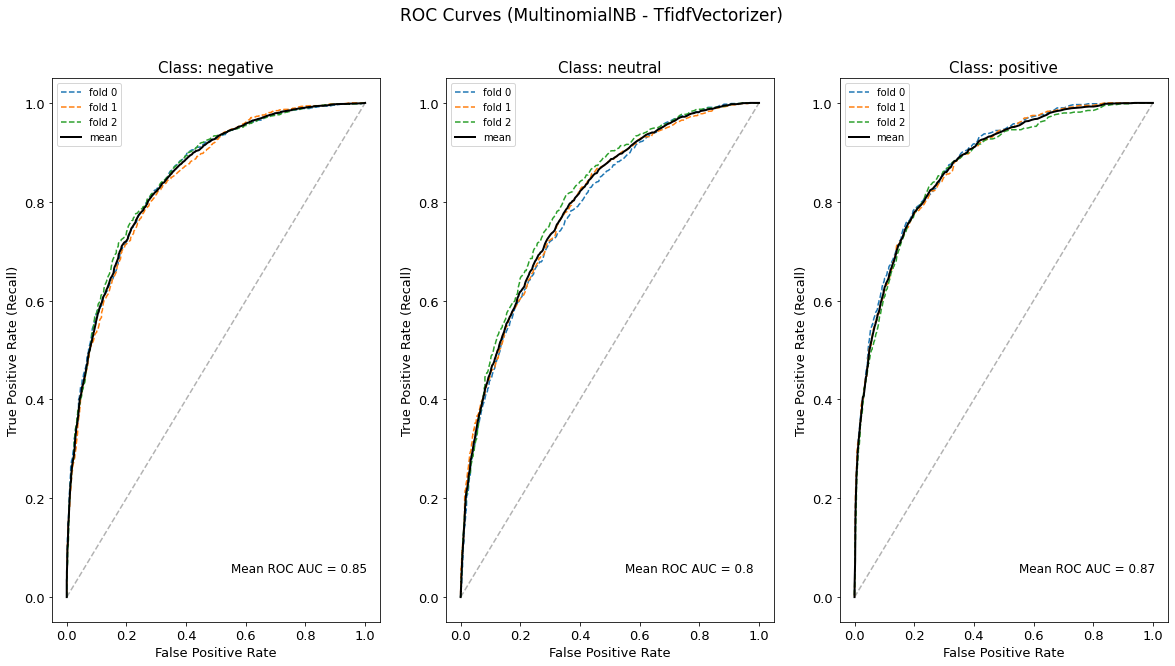

In [99]:
#Tipo de vectorizador
kind = TfidfVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1, 1))
#Cantidad de kfolds a dividir el dataset
splits = 3
#Seleccion de estimador
estimador = MultinomialNB(alpha=1.8)
#Contiene los nombres del vectorizador y estimador respectivamente
vector_strip = str(kind).split('(')[0]
model_strip = str(estimador).split('(')[0]
#Ploteo de resulados
roc_title = f'ROC Curves ({model_strip} - {vector_strip})'
pr_title = f'Precision-Recall Curves ({model_strip} - {vector_strip})'

run_model(kind,splits,estimador,pr_title,roc_title)

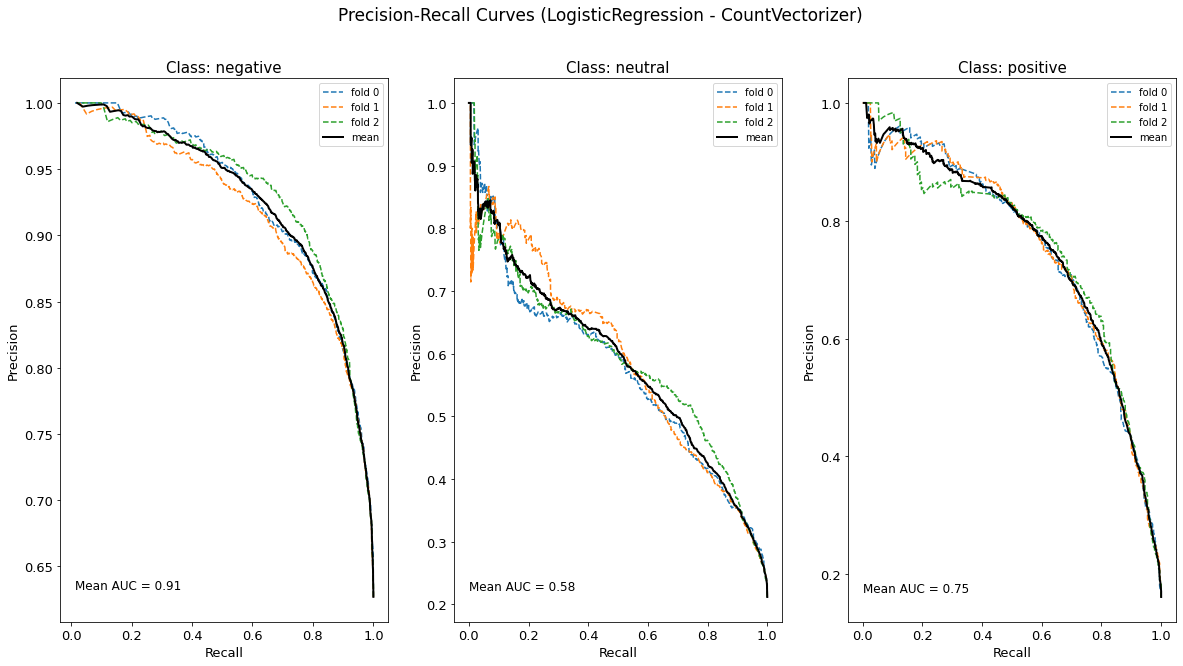

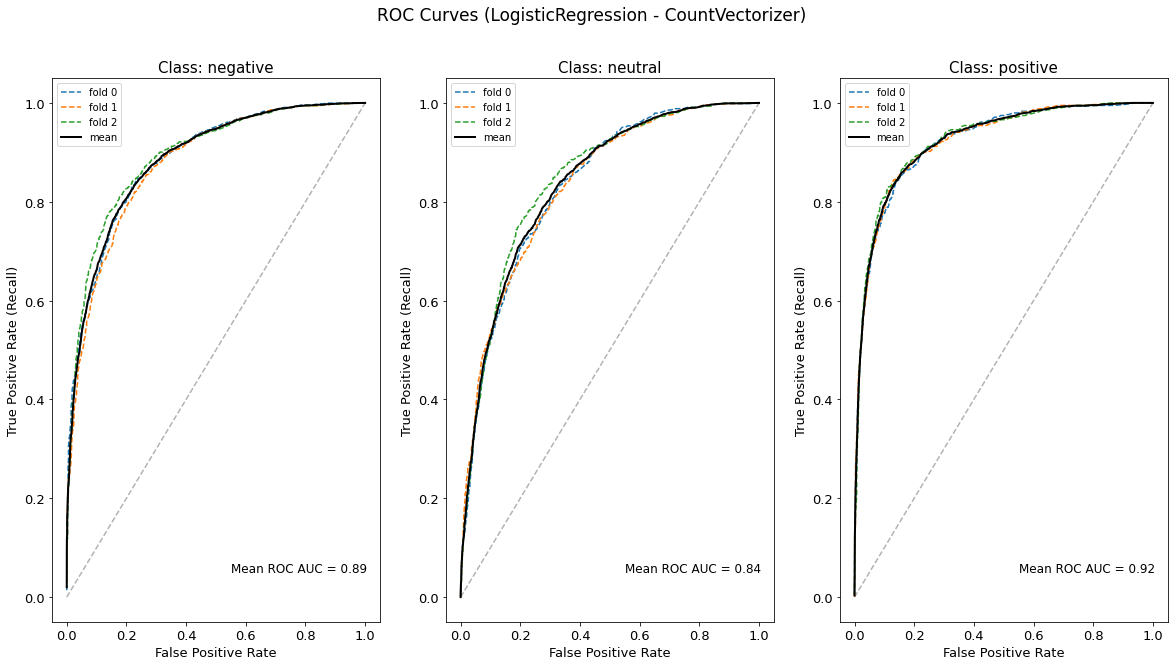

In [100]:
#Tipo de vectorizador
kind = CountVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1, 1))
#Cantidad de kfolds a dividir el dataset
splits = 3
#Seleccion de estimador
estimador = LogisticRegression(C=0.45,max_iter=1000)
#Contiene los nombres del vectorizador y estimador respectivamente
vector_strip = str(kind).split('(')[0]
model_strip = str(estimador).split('(')[0]
#Ploteo de resulados
roc_title = f'ROC Curves ({model_strip} - {vector_strip})'
pr_title = f'Precision-Recall Curves ({model_strip} - {vector_strip})'

run_model(kind,splits,estimador,pr_title,roc_title)

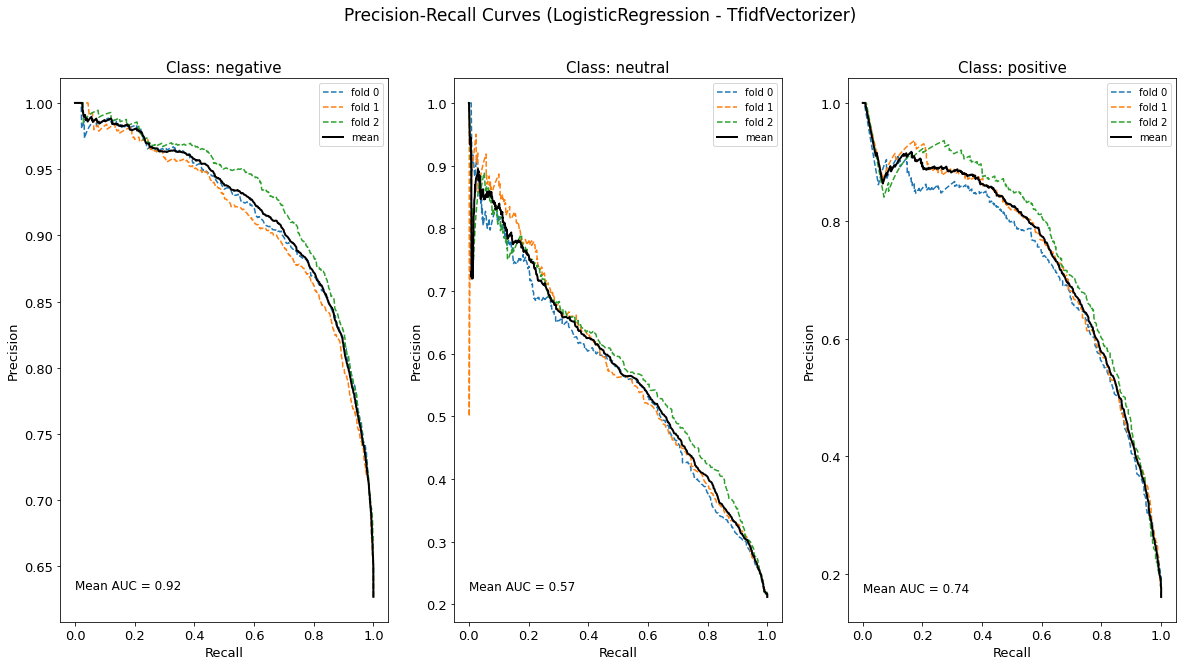

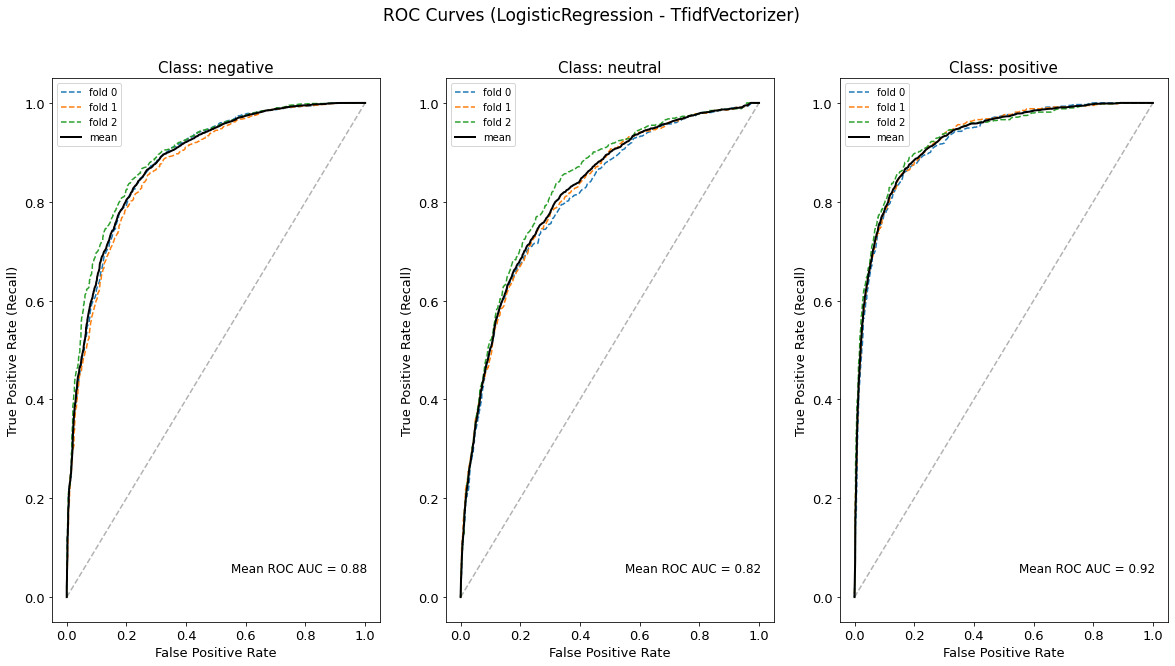

In [101]:
#Tipo de vectorizador
kind = TfidfVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1, 1))
#Cantidad de kfolds a dividir el dataset
splits = 3
#Seleccion de estimador
estimador = LogisticRegression(C=0.45,max_iter=1000)
#Contiene los nombres del vectorizador y estimador respectivamente
vector_strip = str(kind).split('(')[0]
model_strip = str(estimador).split('(')[0]
#Ploteo de resulados
roc_title = f'ROC Curves ({model_strip} - {vector_strip})'
pr_title = f'Precision-Recall Curves ({model_strip} - {vector_strip})'

run_model(kind,splits,estimador,pr_title,roc_title)

In [80]:
#Model with LogisticRegression (CountVectorizer)

skf = StratifiedKFold(n_splits=4,random_state=49,shuffle=True) 
estimador = LogisticRegression(max_iter=250)
param_grid = {'C': np.arange(0.4,0.5,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(x_train,y_train)
print('               LogisticRegression (CountVec)\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: C =", np.round(grid.best_params_['C'],3),'\n')

best_model = grid.best_estimator_
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)

print('Classification report:\n')
print(classification_report(y_test,y_pred))

               LogisticRegression (CountVec)

Best cross-validation score: 0.741
Best parameters: C = 0.49 

Classification report:

              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      2294
     neutral       0.71      0.35      0.47       775
    positive       0.82      0.53      0.64       591

    accuracy                           0.76      3660
   macro avg       0.76      0.61      0.65      3660
weighted avg       0.76      0.76      0.74      3660



<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predichos', ylabel='Verdaderos'>

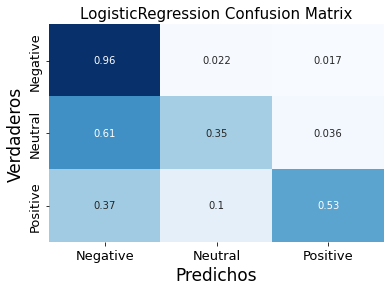

In [81]:
#Visualización de la matriz de confusión para LogisticRegression (CountVectorizer)
def confusion(titulo):
    fig,ax = plt.subplots()
    conf_matrix = confusion_matrix(y_test,y_pred,normalize='true')
    ax = sns.heatmap(conf_matrix,annot=True,cbar= False,cmap='Blues')
    ax.set_xlabel("Predichos",fontsize='17')
    ax.set_ylabel("Verdaderos",fontsize='17')
    ax.set_title(titulo)
    ax.set_xticklabels(['Negative','Neutral','Positive'])
    ax.set_yticklabels(['Negative','Neutral','Positive'],fontdict={'verticalalignment': 'center'})
    return ax

confusion('LogisticRegression Confusion Matrix')

In [82]:
#Model with MultinomialNB (CountVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = MultinomialNB()
param_grid = {'alpha': np.arange(0.5,1,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(x_train,y_train)
print('               MultinomialNB (CountVec)\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: alpha =", np.round(grid.best_params_['alpha'],3),'\n');

best_model = grid.best_estimator_
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)

print('Classification report:\n')
print(classification_report(y_test,y_pred))



               MultinomialNB (CountVec)

Best cross-validation score: 0.705
Best parameters: alpha = 0.5 

Classification report:

              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      2294
     neutral       0.79      0.23      0.36       775
    positive       0.85      0.29      0.43       591

    accuracy                           0.72      3660
   macro avg       0.78      0.50      0.54      3660
weighted avg       0.75      0.72      0.66      3660



In [83]:
confusion_matrix(y_test,y_pred)

array([[2271,   18,    5],
       [ 570,  180,   25],
       [ 390,   29,  172]], dtype=int64)

<AxesSubplot:title={'center':'Multinomial Confusion Matrix'}, xlabel='Predichos', ylabel='Verdaderos'>

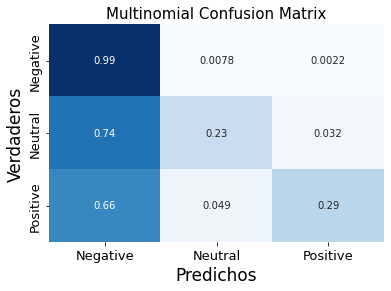

In [84]:
confusion('Multinomial Confusion Matrix')

In [85]:
#Vectorización del set de entrenamiento utilizando TfidVectorizer
vectorizer=TfidfVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1,2));

X_tfidf_train=vectorizer.fit_transform(train);
X_tfidf_test=vectorizer.transform(test)


In [86]:
#Model with LogisticRegression (TfidfVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = LogisticRegression(max_iter=250)
param_grid = {'C': np.arange(1.7,1.8,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(X_tfidf_train,y_train)
print('            LogisticRegression (TfidfVec)\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: C =", np.round(grid.best_params_['C'],3),'\n');

best_model = grid.best_estimator_
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)

print('Classification report:\n')
print(classification_report(y_test,y_pred))


            LogisticRegression (TfidfVec)

Best cross-validation score: 0.738
Best parameters: C = 1.8 

Classification report:

              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      2294
     neutral       0.66      0.47      0.55       775
    positive       0.80      0.59      0.68       591

    accuracy                           0.78      3660
   macro avg       0.75      0.67      0.70      3660
weighted avg       0.77      0.78      0.77      3660



<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predichos', ylabel='Verdaderos'>

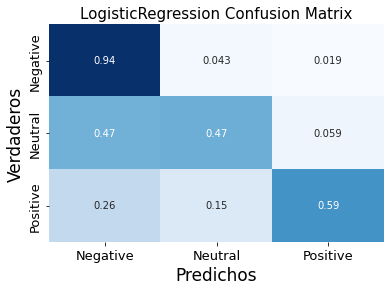

In [87]:
confusion('LogisticRegression Confusion Matrix')

In [88]:
#Model with MultinomialNB (TfidfVectorizer)

skf = StratifiedKFold(n_splits=3,random_state=49,shuffle=True) 
estimador = MultinomialNB()
param_grid = {'alpha': np.arange(0.01,0.5,0.01)} 
grid = GridSearchCV(estimador,param_grid,cv=skf,n_jobs=-1)
grid.fit(X_tfidf_train,y_train)
print('               MultinomialNB (TfidfVec)\n')
print("Best cross-validation score:",np.round(grid.best_score_,3));
print("Best parameters: alpha =", np.round(grid.best_params_['alpha'],3),'\n');

best_model = grid.best_estimator_
best_model.fit(x_train,y_train)
y_pred = best_model.predict(x_test)

print('Classification report:\n')
print(classification_report(y_test,y_pred))


               MultinomialNB (TfidfVec)

Best cross-validation score: 0.738
Best parameters: alpha = 0.14 

Classification report:

              precision    recall  f1-score   support

    negative       0.74      0.97      0.84      2294
     neutral       0.71      0.32      0.44       775
    positive       0.82      0.44      0.57       591

    accuracy                           0.75      3660
   macro avg       0.76      0.58      0.62      3660
weighted avg       0.75      0.75      0.71      3660



<AxesSubplot:title={'center':'Multinomial Confusion Matrix'}, xlabel='Predichos', ylabel='Verdaderos'>

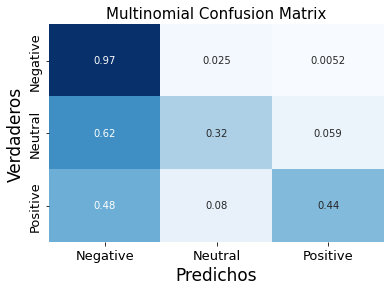

In [89]:
confusion('Multinomial Confusion Matrix')

In [90]:
#Preparación de los datos para reducción de dimensionalidad

from sklearn.feature_extraction.text import TfidfTransformer
vectorizer=CountVectorizer(stop_words=stop_words,strip_accents='unicode',ngram_range=(1, 1))
asd = vectorizer.fit_transform(data["text_clean"])
#Tfidf_encoding=TfidfTransformer().fit_transform(data["text_clean"]);
#pd.DataFrame(Tfidf_encoding.todense(),columns=vectorizer.get_feature_names())
Tfidf_encoding=TfidfTransformer().fit_transform(asd)

In [91]:
index_positive =data['airline_sentiment'][data['airline_sentiment'] == 'positive'].index
index_neutral=data['airline_sentiment'][data['airline_sentiment'] == 'neutral'].index
index_negative =data['airline_sentiment'][data['airline_sentiment'] == 'negative'].index



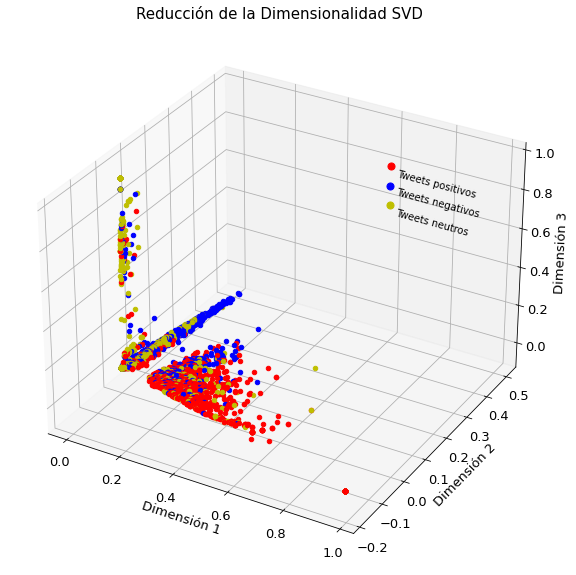

In [102]:
#Reducción de la dimensionalidad utilizando SVD
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=3);
P=svd.fit_transform(Tfidf_encoding)

#Representación gráfica de las 3 componentes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Dimensión 1')
ax.set_ylabel('Dimensión 2')
ax.set_zlabel('Dimensión 3')
ax.set_title('Reducción de la Dimensionalidad SVD')

ax.scatter(0.6,0.5,0.8,color='r',s=50)
ax.text(0.62,0.5,0.65,'Tweets positivos',zdir='x')
ax.scatter(0.6,0.5,0.7,color='b',s=50 ) 
ax.text(0.62,0.5,0.55,'Tweets negativos',zdir='x')
ax.scatter(0.6,0.5,0.6,color='y',s=50 )
ax.text(0.62,0.5,0.45,'Tweets neutros',zdir='x')
for i in range(len(P)):
    if i in index_positive:
        x,y,z=P[i][0],P[i][1],P[i][2]
        ax.scatter(x, y, z,color='r')
       
    elif i in index_negative:
        x,y,z=P[i][0],P[i][1],P[i][2]
        ax.scatter(x, y, z,c='b')
         
    else:
        x,y,z=P[i][0],P[i][1],P[i][2]
        ax.scatter(x, y, z,c='y')


In [93]:
#Palabras con más peso en las componentes principales

comp1 , comp2 , comp3 = svd.components_ # coeficientes (pesos) de los términos en cada una de las 3 dimensiones

indices=np.argsort(comp1); # los ordenamos de menor a mayor y nos quedamos con los índices de sus posiciones en el array
indices=indices[::-1] # invertimos para que queden ordenados de mayor a menor

print('Dimension 1:')
print(np.array(vectorizer.get_feature_names())[indices][:20]) # Evaluamos los términos en estas posiciones

print('\n')

indices=np.argsort(comp2);
indices=indices[::-1]
print('Dimension 2:')
print(np.array(vectorizer.get_feature_names())[indices][:20])
print('\n')
indices=np.argsort(comp3);
indices=indices[::-1]
print('Dimension 3:')
print(np.array(vectorizer.get_feature_names())[indices][:20])




Dimension 1:
['thank' 'much' 'great' 'help' 'service' 'got' 'customer' 'cancelled' 'dm'
 'time' 'guys' 'response' 'sent' 'awesome' 'hold' 'hours' 'good' 'please'
 'ok' 'today']


Dimension 2:
['cancelled' 'hold' 'help' 'led' 'service' 'hours' 'customer' 'please'
 'time' 'call' 'need' 'hour' 'still' 'problem' 'us' 'phone' 'one' 'plane'
 'delayed' 'back']


Dimension 3:
['fleek' 'fleet' 'rt' 'stop' 'please' 'lol' 'smh' 'lmao' 'dm' 'yall' 'wow'
 'see' 'happened' 'really' 'oh' 'hate' 'okay' 'xx' 'know' 'madness']


In [94]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'tweet_long', 'text_clean'],
      dtype='object')

In [95]:
data['airline_sentiment_confidence'][1]

0.3486

(array([2.3600e+02, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.9520e+03,
        1.9890e+03, 2.0000e+00, 1.0000e+00, 7.0000e+00, 1.0451e+04]),
 array([0.335 , 0.4015, 0.468 , 0.5345, 0.601 , 0.6675, 0.734 , 0.8005,
        0.867 , 0.9335, 1.    ]),
 <BarContainer object of 10 artists>)

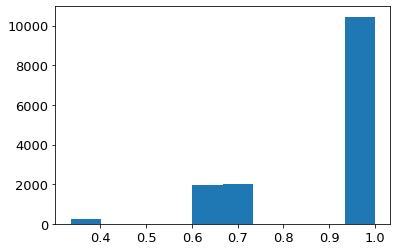

In [96]:
plt.hist(data['airline_sentiment_confidence'])

In [3]:
def repetidos(lista):
    contador_repetidos = 0
    
    for i in lista:
        for j in lista:
            if j == i:
                contador_repetidos = contador_repetidos + 1
        
    if contador_repetidos > 1:
        return True
    else:
        return False
    
        

True

In [7]:
def repetidos_v2(lista):
    lista_verificacion=[]
    
    #recorro la lista y pido que si el elemento i no esta en lista_verificacion, me apendee ese elemento
    for i in lista:
        if i not in lista_verificacion:
            lista_verificacion.append(i)
    
    #si la cantidad de elementos de la lista_verificacion es igual a la cantidad de elementos de la lista (no hay repetidos) devuelve False
    if len(lista_verificacion) == len(lista):
        return False
    else:
        return True
    
repetidos_v2([1,2,5,5,5])

True

In [14]:
def impares_entre(numero):
    #creo lista vacia para appendear numeros que cumplen con la condicion
    lista_impares=[]
    #Itero entre 0 y numero - 1 (ej: range(6) = [0,1,2,3,4,5])
    for i in range(numero):
        #Si el resto de dividir por 2 es distinto a 0, el numero es impar
        if i%2 != 0:
            #Si cumple la condicion appendeo el elemento i
            lista_impares.append(i)
    return lista_impares

impares_entre(11)

[1, 3, 5, 7, 9]

In [16]:
def impares_entre(numero):
    #en vez de crear una lista vacia y hacer todo lo de arriba,
    #hago todo en un paso, es decir que creo la lista_impares que son:
    #los i en el rango (0,1,2,...,numero-1) que cumplan con la condicion que
    #el resto de dividirlos por 2 es distinto a 0
    lista_impares = [i for i in range(numero) if i%2 !=0]
    return lista_impares

impares_entre(11)

[1, 3, 5, 7, 9]